<a href="https://colab.research.google.com/github/Carvalho-Andre/analise_simulacoes_doutorado/blob/main/semantic_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# =========================
# AUTO-DISCOVERY (NO MANUAL PATHS)
# =========================

from google.colab import drive
drive.mount('/content/drive')

import os, glob, re

MYDRIVE = "/content/drive/MyDrive"

def find_first(patterns, root=MYDRIVE):
    """Return first matching path for any glob pattern in patterns."""
    for pat in patterns:
        hits = glob.glob(os.path.join(root, "**", pat), recursive=True)
        if hits:
            # prefer shorter paths (closer to root) to avoid duplicates
            hits = sorted(hits, key=lambda p: (len(p.split(os.sep)), len(p)))
            return hits[0]
    return None

# 1) Find 4chan CSV
PATH_4CHAN_CSV = find_first([
    "4chan_ALL_BOARDS_MULTIMODAL.csv",
    "*4chan*ALL*BOARDS*MULTIMODAL*.csv",
    "*4chan*.csv",
])

# 2) Find Discord CSV
PATH_DISCORD_CSV = find_first([
    "discord_ALL_COMPLETE.csv",
    "*discord*ALL*COMPLETE*.csv",
    "*discord*.csv",
])

# 3) Guess Reddit JSON root
# Find folders that contain many .json with "reddit" in path/name
def find_reddit_root(root=MYDRIVE):
    jsons = glob.glob(os.path.join(root, "**", "*.json"), recursive=True)
    reddit_jsons = [p for p in jsons if "reddit" in p.lower()]
    if not reddit_jsons:
        # fallback: any jsons at all
        return root
    # choose directory with most reddit jsons
    dir_counts = {}
    for p in reddit_jsons:
        d = os.path.dirname(p)
        dir_counts[d] = dir_counts.get(d, 0) + 1
    best_dir = max(dir_counts, key=dir_counts.get)
    # use parent folder of best_dir to allow recursive scan
    return os.path.dirname(best_dir)

PATH_REDDIT_ROOT = find_reddit_root()

# 4) BASE_PATH (optional, for logging)
BASE_PATH = os.path.commonpath([p for p in [PATH_4CHAN_CSV, PATH_DISCORD_CSV, PATH_REDDIT_ROOT] if p])

print("✅ Auto-discovery results:")
print("BASE_PATH:", BASE_PATH)
print("4chan CSV:", PATH_4CHAN_CSV)
print("Discord CSV:", PATH_DISCORD_CSV)
print("Reddit root:", PATH_REDDIT_ROOT)

# Safety checks
if PATH_4CHAN_CSV is None:
    print("⚠️ Could not find 4chan CSV automatically.")
if PATH_DISCORD_CSV is None:
    print("⚠️ Could not find Discord CSV automatically.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Auto-discovery results:
BASE_PATH: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord
4chan CSV: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados/4chan_ALL_BOARDS_MULTIMODAL.csv
Discord CSV: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados/Discord/discord_ALL_COMPLETE.csv
Reddit root: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Reddit


In [32]:
BASE_PATH = "/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord"

PATH_4CHAN_CSV   = "/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados/4chan_ALL_BOARDS_MULTIMODAL.csv"
PATH_DISCORD_CSV = "/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados/Discord/discord_ALL_COMPLETE.csv"
PATH_REDDIT_ROOT = "/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Reddit"

print("BASE_PATH:", BASE_PATH)
print("4chan:", PATH_4CHAN_CSV, "exists?", os.path.exists(PATH_4CHAN_CSV))
print("Discord:", PATH_DISCORD_CSV, "exists?", os.path.exists(PATH_DISCORD_CSV))
print("Reddit root:", PATH_REDDIT_ROOT, "exists?", os.path.exists(PATH_REDDIT_ROOT))


BASE_PATH: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord
4chan: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados/4chan_ALL_BOARDS_MULTIMODAL.csv exists? True
Discord: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Dados Processados/Discord/discord_ALL_COMPLETE.csv exists? True
Reddit root: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Reddit exists? True


In [33]:
import os, glob, json, random
from collections import Counter

jsons = glob.glob(os.path.join(PATH_REDDIT_ROOT, "**", "*.json"), recursive=True)
print("Total JSON files:", len(jsons))

def peek_json(fp):
    try:
        with open(fp, "r", encoding="utf-8", errors="ignore") as f:
            data = json.load(f)
        if isinstance(data, list):
            first = data[0] if data else None
            keys = list(first.keys())[:30] if isinstance(first, dict) else []
            return ("list", len(data), keys)
        if isinstance(data, dict):
            keys = list(data.keys())[:30]
            return ("dict", len(data), keys)
        return (type(data).__name__, None, [])
    except Exception as e:
        return ("error", str(e), [])

# amostra de 8 arquivos para ver o "shape" dos JSONs
for fp in random.sample(jsons, min(8, len(jsons))):
    t, meta, keys = peek_json(fp)
    print("\nJSON:", fp.replace(PATH_REDDIT_ROOT, "").lstrip("/"))
    print("Type:", t, "| meta:", meta)
    if keys:
        print("Keys:", keys)


Total JSON files: 11

JSON: r TooAfraidToAsk/dataset_reddit-scraper_2025-08-11_00-46-23-941.json
Type: list | meta: 101
Keys: ['id', 'parsedId', 'url', 'username', 'userId', 'title', 'communityName', 'parsedCommunityName', 'body', 'html', 'link', 'numberOfComments', 'flair', 'upVotes', 'upVoteRatio', 'isVideo', 'isAd', 'over18', 'thumbnailUrl', 'imageUrls', 'createdAt', 'scrapedAt', 'dataType']

JSON: r conservative/dataset_reddit-scraper_2025-08-11_00-30-47-569.json
Type: list | meta: 100
Keys: ['id', 'parsedId', 'url', 'username', 'userId', 'title', 'communityName', 'parsedCommunityName', 'body', 'html', 'link', 'numberOfComments', 'flair', 'upVotes', 'upVoteRatio', 'isVideo', 'isAd', 'over18', 'thumbnailUrl', 'imageUrls', 'createdAt', 'scrapedAt', 'dataType']

JSON: r politics /dataset_reddit-scraper_2025-08-11_00-49-50-776.json
Type: list | meta: 101
Keys: ['id', 'parsedId', 'url', 'username', 'userId', 'title', 'communityName', 'parsedCommunityName', 'body', 'html', 'link', 'numbe

In [34]:
import os, glob, json, re
import pandas as pd

def _clean_text(x: str) -> str:
    x = "" if x is None else str(x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def load_reddit_scraper_json(root: str, min_chars: int = 20) -> pd.DataFrame:
    files = glob.glob(os.path.join(root, "**", "*.json"), recursive=True)
    rows = []

    for fp in files:
        try:
            with open(fp, "r", encoding="utf-8", errors="ignore") as f:
                data = json.load(f)
        except Exception:
            continue

        if not isinstance(data, list):
            continue

        for it in data:
            if not isinstance(it, dict):
                continue

            title = _clean_text(it.get("title", ""))
            body  = _clean_text(it.get("body", ""))
            text  = _clean_text((title + " " + body).strip())

            if len(text) < min_chars:
                continue

            subgroup = it.get("parsedCommunityName") or it.get("communityName") or "unknown"
            subgroup = str(subgroup).replace("r/", "").strip()

            source_id = it.get("parsedId") or it.get("id") or it.get("url") or os.path.basename(fp)

            rows.append({
                "text": text,
                "network": "Reddit",
                "subgroup": subgroup,
                "source_id": str(source_id),
                "createdAt": it.get("createdAt"),
                "over18": it.get("over18"),
                "isAd": it.get("isAd"),
                "upVotes": it.get("upVotes"),
                "numberOfComments": it.get("numberOfComments"),
            })

    df = pd.DataFrame(rows)

    # filtros defensivos: remover ads e (opcional) over18
    if not df.empty and "isAd" in df.columns:
        df = df[df["isAd"] != True].copy()

    df.reset_index(drop=True, inplace=True)
    return df

df_reddit = load_reddit_scraper_json(PATH_REDDIT_ROOT, min_chars=20)

print("✅ Reddit rows loaded:", len(df_reddit))
if len(df_reddit):
    print("\nTop subgroups:")
    print(df_reddit["subgroup"].value_counts().head(15))
    print("\nSample:")
    display(df_reddit.sample(min(5, len(df_reddit)), random_state=42))
else:
    print("⚠️ Zero rows. Something is off with PATH_REDDIT_ROOT or JSON encoding.")


✅ Reddit rows loaded: 1024

Top subgroups:
subgroup
politics                 101
worldnews                100
news                      99
TooAfraidToAsk            97
Conservative              96
Liberal                   96
offmychest                96
CasualConversation        94
PoliticalCompassMemes     92
AskReddit                 92
RepLuxurySelect           32
Ask_Politics              29
Name: count, dtype: int64

Sample:


,text,network,subgroup,source_id,createdAt,over18,isAd,upVotes,numberOfComments
525,Misunderstanding of statistics is why casinos ...,Reddit,news,n6tr8mu,2025-08-04T06:15:21.000Z,None,None,78,NaN
357,Its funny cause like before Trump If you said ...,Reddit,PoliticalCompassMemes,n6on09w,2025-08-03T12:27:42.000Z,None,None,12,NaN
444,Welcome to /r/ask_politics. Our goal here is t...,Reddit,Ask_Politics,m9k675b,2025-01-28T01:24:17.000Z,None,None,1,NaN
31,And then 2 days later it tuns out that it's ex...,Reddit,politics,n6xgwtt,2025-08-04T19:55:40.000Z,None,None,22,NaN
618,They're treating these kidnapped Ukrainian kid...,Reddit,worldnews,n7frz80,2025-08-07T15:53:48.000Z,None,None,6,NaN


In [35]:
# 3) REDDIT CLEAN DATASET (balanced core)
min_per_sub = 90

counts = df_reddit["subgroup"].value_counts()
keep_subs = counts[counts >= min_per_sub].index.tolist()

df_reddit_clean = df_reddit[df_reddit["subgroup"].isin(keep_subs)].copy()
df_reddit_clean.reset_index(drop=True, inplace=True)

print("Keeping subgroups (>=90):", keep_subs)
print("✅ Reddit clean rows:", len(df_reddit_clean))
print(df_reddit_clean["subgroup"].value_counts())


Keeping subgroups (>=90): ['politics', 'worldnews', 'news', 'TooAfraidToAsk', 'Conservative', 'Liberal', 'offmychest', 'CasualConversation', 'PoliticalCompassMemes', 'AskReddit']
✅ Reddit clean rows: 963
subgroup
politics                 101
worldnews                100
news                      99
TooAfraidToAsk            97
Conservative              96
Liberal                   96
offmychest                96
CasualConversation        94
PoliticalCompassMemes     92
AskReddit                 92
Name: count, dtype: int64


In [36]:
import pandas as pd

# lê só um pedaço para ser rápido
df4 = pd.read_csv(PATH_4CHAN_CSV, nrows=200)
dfd = pd.read_csv(PATH_DISCORD_CSV, nrows=200)

print("4chan columns:", df4.columns.tolist())
print("discord columns:", dfd.columns.tolist())

print("\n4chan sample:")
display(df4.head(3))

print("\ndiscord sample:")
display(dfd.head(3))


4chan columns: ['screenshot_id', 'board', 'sequence', 'user', 'post_number', 'timestamp', 'reply_to', 'has_image', 'text_content', 'char_count', 'word_count', 'processing_date', 'text_sentiment', 'text_sentiment_score', 'visual_category_1', 'visual_score_1', 'visual_category_2', 'visual_score_2', 'visual_category_3', 'visual_score_3', 'visual_class', 'combined_sentiment_score', 'combined_sentiment']
discord columns: ['screenshot_id', 'channel', 'source', 'user', 'message_id', 'timestamp', 'has_attachment', 'reactions', 'text_content', 'char_count', 'word_count', 'processing_date']

4chan sample:


,screenshot_id,board,sequence,user,post_number,timestamp,reply_to,has_image,text_content,char_count,...,text_sentiment_score,visual_category_1,visual_score_1,visual_category_2,visual_score_2,visual_category_3,visual_score_3,visual_class,combined_sentiment_score,combined_sentiment
0,4chan_b_randow__1.png,unknown,0,User_001,NaN,NaN,NaN,False,[Hide] [Show All] You are Biocked trom followi...,175,...,-0.1779,humor or joke,0.373792,military content,0.143514,violent imagery,0.121104,neutral,-0.1779,negative
1,4chan_b_randow__10.png,unknown,0,User_001,938067964.0,08/06/25(Wed)00:13:22,929062027.0,False,tuck I wish she would cut the shit and just do...,52,...,0.6808,hate symbol,0.226515,violent imagery,0.161692,military content,0.105125,potentially_harmful,0.3808,positive
2,4chan_b_randow__10.png,unknown,0,User_001,938067984.0,08/06/25(Wed)00:13:50,938008027.0,False,‘Got raped once in high school by a black man ...,128,...,-0.3182,hate symbol,0.226515,violent imagery,0.161692,military content,0.105125,potentially_harmful,-0.6182,negative



discord sample:


,screenshot_id,channel,source,user,message_id,timestamp,has_attachment,reactions,text_content,char_count,word_count,processing_date
0,Screenshot 2025-09-04 183906.png,root,discord,User_000,NaN,NaN,False,NaN,"S&S NotASadist 12/5/12, 10:35 Pm.\nYo’ if you ...",365,72,2026-02-04 11:11:25
1,Screenshot 2025-09-04 183931.png,root,discord,User_000,NaN,NaN,False,NaN,Be Ue\n@ Rl eee\nno.\nstop trying to act like ...,223,49,2026-02-04 11:11:27
2,Screenshot 2025-09-04 183942.png,root,discord,User_001,NaN,11:33 AM,False,NaN,Bd amelie),11,2,2026-02-04 11:11:28


In [37]:
import pandas as pd
import re

def _clean_text(x: str) -> str:
    x = "" if x is None else str(x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

# -------- 4chan deterministic loader --------
df4_raw = pd.read_csv(PATH_4CHAN_CSV)

df4 = pd.DataFrame({
    "text": df4_raw["text_content"].map(_clean_text),
    "network": "4Chan",
    "subgroup": df4_raw["board"].fillna("unknown").astype(str),
    "source_id": df4_raw["screenshot_id"].astype(str) + "::" + df4_raw.index.astype(str),
    "word_count": df4_raw["word_count"] if "word_count" in df4_raw.columns else None,
    "char_count": df4_raw["char_count"] if "char_count" in df4_raw.columns else None,
})

# filtros: texto mínimo + remover UI trash comum
mask_ui = df4["text"].str.contains(r"^\[Hide\]\s*\[Show All\]|^\[Show All\]", case=False, regex=True, na=False)

df_4chan_clean = df4[(df4["text"].str.len() >= 30) & (~mask_ui)].copy()
df_4chan_clean.reset_index(drop=True, inplace=True)

print("✅ 4chan raw:", len(df4), "| clean:", len(df_4chan_clean))
print(df_4chan_clean["subgroup"].value_counts().head(10))


# -------- Discord deterministic loader --------
dfd_raw = pd.read_csv(PATH_DISCORD_CSV)

dfd = pd.DataFrame({
    "text": dfd_raw["text_content"].map(_clean_text),
    "network": "Discord",
    "subgroup": dfd_raw["channel"].fillna("unknown").astype(str),
    "source_id": dfd_raw["screenshot_id"].astype(str) + "::" + dfd_raw.index.astype(str),
    "word_count": dfd_raw["word_count"] if "word_count" in dfd_raw.columns else None,
    "char_count": dfd_raw["char_count"] if "char_count" in dfd_raw.columns else None,
})

# filtros: remover muito curto e lixo OCR
df_discord_clean = dfd[(dfd["text"].str.len() >= 30) & (dfd["word_count"].fillna(0) >= 6)].copy()
df_discord_clean.reset_index(drop=True, inplace=True)

print("\n✅ Discord raw:", len(dfd), "| clean:", len(df_discord_clean))
print(df_discord_clean["subgroup"].value_counts().head(10))


# -------- Reddit: assume df_reddit_clean já existe --------
df_reddit_ready = df_reddit_clean[["text", "network", "subgroup", "source_id"]].copy()
df_4chan_ready = df_4chan_clean[["text", "network", "subgroup", "source_id"]].copy()
df_discord_ready = df_discord_clean[["text", "network", "subgroup", "source_id"]].copy()

df_mega = pd.concat([df_reddit_ready, df_4chan_ready, df_discord_ready], ignore_index=True)

print("\n=========================")
print("✅ Unified df_mega:", len(df_mega))
print(df_mega.groupby("network").size())
print("=========================\n")

display(df_mega.sample(5, random_state=42))


✅ 4chan raw: 3287 | clean: 3050
subgroup
unknown    2671
/news/      286
/pol/        93
Name: count, dtype: int64

✅ Discord raw: 2301 | clean: 1880
subgroup
root    1880
Name: count, dtype: int64

✅ Unified df_mega: 5893
network
4Chan      3050
Discord    1880
Reddit      963
dtype: int64



,text,network,subgroup,source_id
3227,https://www.timesofisrael. com/after-trump-rej...,4Chan,unknown,Screenshot 2025-10-12 172944.png::2427
5013,Rae aate aT] CU ee Boe Oe EL Pee eC eg |,Discord,root,Screenshot 2025-09-22 204254.png::1235
3318,221441686 Trump did want to get bleach inside ...,4Chan,unknown,Screenshot 2025-10-12 174715.png::2536
2144,"Don't worry about it, you won. And you're happ...",4Chan,unknown,Screenshot 2025-10-12 145948.png::1266
3606,DoJ is asking for a 30 year sentence for the l...,4Chan,unknown,Screenshot 2025-10-12 182240.png::2849


In [38]:
import re

# --- 4chan: tentar extrair board do screenshot_id quando subgroup == 'unknown'
def infer_4chan_board(sid: str) -> str:
    sid = str(sid).lower()
    # padrões possíveis
    # ex: 4chan_b_random__10.png  -> /b/
    m = re.search(r"4chan[_\-]([a-z0-9]+)[_\-]", sid)
    if m:
        b = m.group(1)
        return f"/{b}/"
    # às vezes aparece como "4chan_b_" ou "4chan_pol_"
    m = re.search(r"4chan[_\-]([a-z0-9]+)", sid)
    if m:
        b = m.group(1)
        return f"/{b}/"
    return "unknown"

# aplica só em 4chan
mask_4chan = df_mega["network"] == "4Chan"
df_mega.loc[mask_4chan, "subgroup"] = df_mega.loc[mask_4chan].apply(
    lambda r: infer_4chan_board(r["source_id"].split("::")[0]) if r["subgroup"] == "unknown" else r["subgroup"],
    axis=1
)

print("✅ 4chan subgroup distribution (after inference):")
print(df_mega[df_mega["network"]=="4Chan"]["subgroup"].value_counts().head(15))

# --- Discord: tentar substituir 'root' por 'source' quando fizer sentido
mask_discord = df_mega["network"] == "Discord"

# Precisamos do df_discord_clean original para acessar 'source' (se tiver)
# Vamos reconstruir um mapa source_id -> source a partir do CSV
dfd_raw = pd.read_csv(PATH_DISCORD_CSV)
dfd_raw["source_id"] = dfd_raw["screenshot_id"].astype(str) + "::" + dfd_raw.index.astype(str)

if "source" in dfd_raw.columns:
    src_map = dict(zip(dfd_raw["source_id"], dfd_raw["source"].fillna("root").astype(str)))
    def fix_discord_subgroup(row):
        if row["network"] != "Discord":
            return row["subgroup"]
        if row["subgroup"] != "root":
            return row["subgroup"]
        s = src_map.get(row["source_id"], "root")
        return s if s and s != "root" else "root"
    df_mega["subgroup"] = df_mega.apply(fix_discord_subgroup, axis=1)

print("\n✅ Discord subgroup distribution (after inference):")
print(df_mega[df_mega["network"]=="Discord"]["subgroup"].value_counts().head(15))


✅ 4chan subgroup distribution (after inference):
subgroup
unknown    2623
/news/      286
/pol/        93
/b/          48
Name: count, dtype: int64

✅ Discord subgroup distribution (after inference):
subgroup
discord    1880
Name: count, dtype: int64


✅ df_mega size: 5893
network
4Chan      3050
Discord    1880
Reddit      963
dtype: int64

✅ df_micro size: 1342
network  subgroup             
4Chan    /news/                   286
Reddit   politics                 101
         worldnews                100
         news                      99
         TooAfraidToAsk            97
         Conservative              96
         offmychest                96
         Liberal                   96
         CasualConversation        94
4Chan    /pol/                     93
Reddit   AskReddit                 92
         PoliticalCompassMemes     92
dtype: int64

🧠 Loading SBERT model...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Encoding df_mega...


Batches:   0%|          | 0/185 [00:00<?, ?it/s]

Encoding df_micro...


Batches:   0%|          | 0/42 [00:00<?, ?it/s]


📊 MACRO (network vs cluster_macro)
Homogeneity:  0.5587
Completeness: 0.6179

📊 MICRO (subgroup vs cluster_micro)  [Reddit + 4chan /pol/ /news/]
K_micro:      12
Homogeneity:  0.3607
Completeness: 0.3716

🔍 Entropy by macro cluster (network mixing):
Cluster 00 | size=3468 | dom=4Chan   | entropy=0.692
Cluster 01 | size= 588 | dom=4Chan   | entropy=0.041
Cluster 02 | size=1837 | dom=Discord | entropy=0.099

🎨 Running t-SNE on df_mega (can take time)...


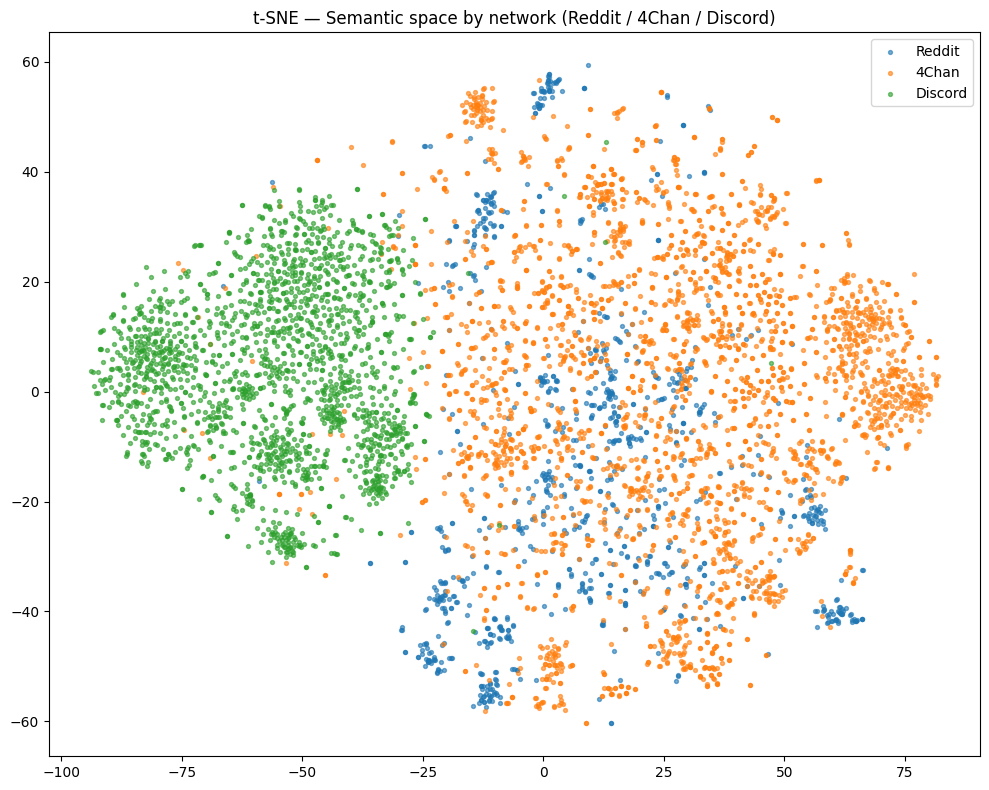

💾 Saved: universal_map_final.png


In [39]:
import numpy as np
import pandas as pd
import random
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# -------------------------
# 1) Prepare "micro-valid" subset
# -------------------------
# Micro usable: Reddit (all) + 4chan only /pol/ and /news/
micro_mask = (
    (df_mega["network"] == "Reddit") |
    ((df_mega["network"] == "4Chan") & (df_mega["subgroup"].isin(["/pol/", "/news/"])))
)
df_micro = df_mega[micro_mask].copy().reset_index(drop=True)

print("✅ df_mega size:", len(df_mega))
print(df_mega.groupby("network").size())
print("\n✅ df_micro size:", len(df_micro))
print(df_micro.groupby(["network","subgroup"]).size().sort_values(ascending=False).head(15))

# -------------------------
# 2) Embeddings (SBERT)
# -------------------------
print("\n🧠 Loading SBERT model...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")

print("Encoding df_mega...")
emb_mega = embedder.encode(df_mega["text"].tolist(), show_progress_bar=True)

print("Encoding df_micro...")
emb_micro = embedder.encode(df_micro["text"].tolist(), show_progress_bar=True)

# -------------------------
# 3) MACRO clustering: separate networks
# -------------------------
K_macro = df_mega["network"].nunique()
km_macro = KMeans(n_clusters=K_macro, random_state=SEED, n_init=10)
df_mega["cluster_macro"] = km_macro.fit_predict(emb_mega)

h_macro = homogeneity_score(df_mega["network"], df_mega["cluster_macro"])
c_macro = completeness_score(df_mega["network"], df_mega["cluster_macro"])

print("\n📊 MACRO (network vs cluster_macro)")
print(f"Homogeneity:  {h_macro:.4f}")
print(f"Completeness: {c_macro:.4f}")

# -------------------------
# 4) MICRO clustering: subgroups where subgroup is meaningful
# -------------------------
K_micro = df_micro["subgroup"].nunique()
km_micro = KMeans(n_clusters=K_micro, random_state=SEED, n_init=10)
df_micro["cluster_micro"] = km_micro.fit_predict(emb_micro)

h_micro = homogeneity_score(df_micro["subgroup"], df_micro["cluster_micro"])
c_micro = completeness_score(df_micro["subgroup"], df_micro["cluster_micro"])

print("\n📊 MICRO (subgroup vs cluster_micro)  [Reddit + 4chan /pol/ /news/]")
print(f"K_micro:      {K_micro}")
print(f"Homogeneity:  {h_micro:.4f}")
print(f"Completeness: {c_micro:.4f}")

# -------------------------
# 5) Entropy: how mixed are networks inside macro clusters?
# -------------------------
def entropy(labels) -> float:
    vals, counts = np.unique(labels, return_counts=True)
    p = counts / counts.sum()
    return float(-(p * np.log(p + 1e-12)).sum())

print("\n🔍 Entropy by macro cluster (network mixing):")
for cid in sorted(df_mega["cluster_macro"].unique()):
    sub = df_mega[df_mega["cluster_macro"] == cid]
    e = entropy(sub["network"])
    dom = sub["network"].mode()[0]
    print(f"Cluster {cid:02d} | size={len(sub):4d} | dom={dom:<7} | entropy={e:.3f}")

# -------------------------
# 6) t-SNE visualization (macro)
# -------------------------
print("\n🎨 Running t-SNE on df_mega (can take time)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=SEED, init="pca", learning_rate="auto")
coords = tsne.fit_transform(emb_mega)

df_mega["x"] = coords[:,0]
df_mega["y"] = coords[:,1]

plt.figure(figsize=(10,8))
for net in df_mega["network"].unique():
    s = df_mega[df_mega["network"]==net]
    plt.scatter(s["x"], s["y"], s=8, alpha=0.6, label=net)
plt.legend()
plt.title("t-SNE — Semantic space by network (Reddit / 4Chan / Discord)")
plt.tight_layout()
plt.savefig("universal_map_final.png", dpi=300)
plt.show()

print("💾 Saved: universal_map_final.png")


In [40]:
import re
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score

def strip_urls(text):
    return re.sub(r"http\S+|www\.\S+", " ", text)

def ocr_garbage_score(text):
    # heurística: muitos caracteres não alfabéticos e muitos tokens pequenos
    t = text
    if not t:
        return 0
    non_alpha = sum(1 for ch in t if not ch.isalnum() and not ch.isspace())
    ratio_non_alpha = non_alpha / max(len(t), 1)

    tokens = re.findall(r"\S+", t)
    short_tokens = sum(1 for tok in tokens if len(tok) <= 2)
    ratio_short = short_tokens / max(len(tokens), 1)

    return 0.6*ratio_non_alpha + 0.4*ratio_short

df_clean2 = df_mega.copy()

# remove URLs
df_clean2["text2"] = df_clean2["text"].apply(strip_urls)

# remove garbage OCR alto
df_clean2["garb"] = df_clean2["text2"].apply(ocr_garbage_score)

# threshold conservador: remove top 10% mais "garbage"
thr = df_clean2["garb"].quantile(0.90)
df_clean2 = df_clean2[df_clean2["garb"] <= thr].copy()
df_clean2["text2"] = df_clean2["text2"].str.replace(r"\s+", " ", regex=True).str.strip()

print("✅ Before:", len(df_mega), "| After:", len(df_clean2), "| garbage_thr:", thr)

# embeddings de novo (só para macro, para ser mais rápido você pode samplear)
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer("all-MiniLM-L6-v2")

emb2 = embedder.encode(df_clean2["text2"].tolist(), show_progress_bar=True)

K_macro = df_clean2["network"].nunique()
km = KMeans(n_clusters=K_macro, random_state=42, n_init=10)
clusters = km.fit_predict(emb2)

h = homogeneity_score(df_clean2["network"], clusters)
c = completeness_score(df_clean2["network"], clusters)

print("\n📊 MACRO after cleaning (network vs clusters)")
print(f"Homogeneity:  {h:.4f}")
print(f"Completeness: {c:.4f}")


✅ Before: 5893 | After: 5303 | garbage_thr: 0.19153048615603682


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/166 [00:00<?, ?it/s]


📊 MACRO after cleaning (network vs clusters)
Homogeneity:  0.5255
Completeness: 0.5881


In [41]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score
from sentence_transformers import SentenceTransformer

df_ctrl = df_clean2.copy()

# se word_count está vazio em algum, recompute
df_ctrl["wc"] = df_ctrl["text2"].apply(lambda x: len(str(x).split()))

# faixa "média" (ajustável)
df_ctrl = df_ctrl[(df_ctrl["wc"] >= 10) & (df_ctrl["wc"] <= 50)].copy()
df_ctrl.reset_index(drop=True, inplace=True)

print("✅ Controlled dataset size:", len(df_ctrl))
print(df_ctrl.groupby("network").size())

embedder = SentenceTransformer("all-MiniLM-L6-v2")
emb_ctrl = embedder.encode(df_ctrl["text2"].tolist(), show_progress_bar=True)

K_macro = df_ctrl["network"].nunique()
km = KMeans(n_clusters=K_macro, random_state=42, n_init=10)
cl = km.fit_predict(emb_ctrl)

h = homogeneity_score(df_ctrl["network"], cl)
c = completeness_score(df_ctrl["network"], cl)

print("\n📊 MACRO after cleaning + length control")
print(f"Homogeneity:  {h:.4f}")
print(f"Completeness: {c:.4f}")


✅ Controlled dataset size: 3342
network
4Chan      1892
Discord     859
Reddit      591
dtype: int64


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/105 [00:00<?, ?it/s]


📊 MACRO after cleaning + length control
Homogeneity:  0.5454
Completeness: 0.5895


In [42]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score

# Reuse embeddings from 7B? If you still have emb_ctrl in memory, use it.
# If not, re-encode quickly:
# emb_ctrl = embedder.encode(df_ctrl["text2"].tolist(), show_progress_bar=True)

K_macro = df_ctrl["network"].nunique()
km = KMeans(n_clusters=K_macro, random_state=42, n_init=10)
df_ctrl["cluster_macro"] = km.fit_predict(emb_ctrl)

def entropy(labels) -> float:
    vals, counts = np.unique(labels, return_counts=True)
    p = counts / counts.sum()
    return float(-(p * np.log(p + 1e-12)).sum())

print("Entropy by cluster (network mixing):")
rows = []
for cid in sorted(df_ctrl["cluster_macro"].unique()):
    sub = df_ctrl[df_ctrl["cluster_macro"]==cid]
    e = entropy(sub["network"])
    dom = sub["network"].mode()[0]
    rows.append((cid, len(sub), dom, e))
    print(f"Cluster {cid:02d} | size={len(sub):4d} | dom={dom:<7} | entropy={e:.3f}")

# cluster mais misto
best = sorted(rows, key=lambda x: x[3], reverse=True)[0]
print("\n✅ Most mixed cluster:", best)


Entropy by cluster (network mixing):
Cluster 00 | size=2078 | dom=4Chan   | entropy=0.672
Cluster 01 | size= 840 | dom=Discord | entropy=0.085
Cluster 02 | size= 424 | dom=4Chan   | entropy=0.042

✅ Most mixed cluster: (np.int32(0), 2078, '4Chan', 0.67194047506368)


In [43]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

mixed_cid = 0
df_mix = df_ctrl[df_ctrl["cluster_macro"] == mixed_cid].copy()

print("✅ Mixed cluster size:", len(df_mix))
print(df_mix["network"].value_counts())

# --- TF-IDF: termos mais característicos do cluster misto ---
# stopwords inglesas básicas; você pode ampliar depois
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=4000,
    ngram_range=(1,2),
    min_df=5
)

X = vectorizer.fit_transform(df_mix["text2"].astype(str))
terms = np.array(vectorizer.get_feature_names_out())

# score médio por termo (mais alto = mais característico no cluster)
mean_scores = np.asarray(X.mean(axis=0)).ravel()
top_idx = mean_scores.argsort()[::-1][:30]

top_terms = pd.DataFrame({
    "term": terms[top_idx],
    "mean_tfidf": mean_scores[top_idx]
})

print("\n🔑 Top terms in mixed cluster (TF-IDF mean):")
display(top_terms)

# --- Exemplos por plataforma ---
def sample_texts(df, net, n=5):
    sub = df[df["network"]==net]
    if len(sub) == 0:
        return []
    return sub.sample(min(n, len(sub)), random_state=42)["text2"].tolist()

for net in ["Reddit", "4Chan", "Discord"]:
    samples = sample_texts(df_mix, net, n=5)
    print(f"\n===== {net} samples ({len(samples)}) =====")
    for i, t in enumerate(samples, 1):
        # truncar para leitura
        tt = t[:250] + ("..." if len(t) > 250 else "")
        print(f"{i}. {tt}")


✅ Mixed cluster size: 2078
network
4Chan      1457
Reddit      588
Discord      33
Name: count, dtype: int64

🔑 Top terms in mixed cluster (TF-IDF mean):


,term,mean_tfidf
0,just,0.027421
1,like,0.022109
2,trump,0.020985
3,people,0.020509
4,don,0.017576
5,time,0.013296
6,think,0.013257
7,right,0.013103
8,know,0.011912
9,shit,0.011272



===== Reddit samples (5) =====
1. Really when you think about it, they might as well be lol. Reclusive creatures hanging out in the opposite of regular human places
2. Nope. God forbid Obama took a week at camp David and they lost their shit for months.
3. Southern sweet tea. I cannot drink it straight, it is sickeningly sweet. I can dilute it with unsweet tea in a 1:3 ratio and that is enough sweetness to me.
4. Also why is the biggest idiot in the middle might well invite Kim and Xi along for an audience- where is Europe and why aren’t they showing trust and honesty outplays a useless idiot
5. Unironically they are. They should just open up a food bank or actually enforce the law over stealing which is the reason businesses are fleeing "food deserts"

===== 4Chan samples (5) =====
1. NTA, but you don't have to run a conversion camp to think of putting LGBT back in its place as mentally ill society-destroying inhuman reprobates as a W. That's a win for all normal people and a loss fo

In [44]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

# 1) stopwords extra (além do english)
extra_stops = set([
    "just","like","dont","don","doesn","didn","isn","aren","wasn","weren","ll","ve","im","ive","youre","weve",
    "yeah","gonna","wanna","shit","fucking","fuck","rt","amp"
])

def basic_clean(text):
    t = str(text).lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)           # urls
    t = re.sub(r"[^a-z0-9\s]", " ", t)                # keep alnum
    t = re.sub(r"\s+", " ", t).strip()
    return t

df_tmp = df_ctrl.copy()
df_tmp["t"] = df_tmp["text2"].apply(basic_clean)

# 2) documentos: cluster 00 vs resto
docs_in = df_tmp[df_tmp["cluster_macro"]==0]["t"].tolist()
docs_out = df_tmp[df_tmp["cluster_macro"]!=0]["t"].tolist()

# 3) CountVectorizer (unigram + bigram)
vec = CountVectorizer(stop_words="english", ngram_range=(1,2), min_df=10, max_df=0.6)
X_in  = vec.fit_transform(docs_in)
terms = np.array(vec.get_feature_names_out())

# remover extra stops pós-hoc (rápido e eficaz)
mask_keep = np.array([all(w not in extra_stops for w in term.split()) for term in terms])
terms = terms[mask_keep]
X_in = X_in[:, mask_keep]

# 4) c-TF-IDF: frequência normalizada por cluster (aqui cluster único)
tf = X_in.sum(axis=0)
tf = np.asarray(tf).ravel()

# idf calculado no "corpus total" (in + out), aproximado
X_out = vec.transform(docs_out)[:, mask_keep]
df_all = (X_in > 0).sum(axis=0) + (X_out > 0).sum(axis=0)
df_all = np.asarray(df_all).ravel()

N = len(docs_in) + len(docs_out)
idf = np.log((N + 1) / (df_all + 1)) + 1

c_tfidf = tf * idf
top_idx = np.argsort(c_tfidf)[::-1][:30]

top = pd.DataFrame({
    "term": terms[top_idx],
    "c_tfidf": c_tfidf[top_idx]
})

print("✅ Differential c-TF-IDF (cluster 00 vs rest):")
display(top)


✅ Differential c-TF-IDF (cluster 00 vs rest):


,term,c_tfidf
0,trump,783.309527
1,people,770.372455
2,think,477.360203
3,right,451.834924
4,time,450.191480
5,know,402.164146
6,good,376.311171
7,actually,352.521315
8,said,334.707535
9,government,316.298362


In [45]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer

def basic_clean(text):
    t = str(text).lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

# cluster misto
df_mix = df_ctrl[df_ctrl["cluster_macro"]==0].copy()
df_mix["t"] = df_mix["text2"].apply(basic_clean)

# focar só em Reddit vs 4chan
df_r = df_mix[df_mix["network"]=="Reddit"].copy()
df_c = df_mix[df_mix["network"]=="4Chan"].copy()

print("Sizes in mixed cluster:")
print("Reddit:", len(df_r), "| 4Chan:", len(df_c), "| Discord:", (df_mix["network"]=="Discord").sum())

# stopwords mais agressivas
extra_stops = set("""
just like people think right time know good actually said make way want say really got need thing going years
did don doesnt didnt isnt arent wasnt werent ll ive youre im yeah
""".split())

vec = CountVectorizer(stop_words="english", ngram_range=(1,2), min_df=8, max_df=0.7)

X = vec.fit_transform(df_mix["t"])
terms = np.array(vec.get_feature_names_out())

# remove extra stops pós-hoc
mask_keep = np.array([all(w not in extra_stops for w in term.split()) for term in terms])
terms = terms[mask_keep]
X = X[:, mask_keep]

# soma por plataforma
mask_r = (df_mix["network"].values == "Reddit")
mask_c = (df_mix["network"].values == "4Chan")

Xr = np.asarray(X[mask_r].sum(axis=0)).ravel()
Xc = np.asarray(X[mask_c].sum(axis=0)).ravel()

# log-odds simples (com suavização)
alpha = 1.0
pr = (Xr + alpha) / (Xr.sum() + alpha*len(Xr))
pc = (Xc + alpha) / (Xc.sum() + alpha*len(Xc))
logodds = np.log(pr) - np.log(pc)

top_reddit = np.argsort(logodds)[::-1][:25]
top_4chan  = np.argsort(logodds)[:25]

df_top = pd.DataFrame({
    "reddit_terms": terms[top_reddit],
    "reddit_logodds": logodds[top_reddit],
    "4chan_terms": terms[top_4chan],
    "4chan_logodds": logodds[top_4chan]
})

print("\n✅ Differential terms within mixed cluster (Reddit vs 4Chan):")
display(df_top)


Sizes in mixed cluster:
Reddit: 588 | 4Chan: 1457 | Discord: 33

✅ Differential terms within mixed cluster (Reddit vs 4Chan):


,reddit_terms,reddit_logodds,4chan_terms,4chan_logodds
0,gt,3.966897,file,-3.104676
1,fish,3.219683,kb,-3.002894
2,dad,2.968368,anon,-2.947834
3,russian,2.727206,jpg,-2.532890
4,canada,2.631896,shill,-2.427529
5,ukraine,2.344214,police,-2.411529
6,ukrainian,2.321741,click,-2.378739
7,father,2.226431,click view,-2.309746
8,russia,2.175138,faggot,-2.235638
9,remember,2.121070,portland,-2.155596


In [46]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer

def basic_clean(text):
    t = str(text).lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df_mix = df_ctrl[df_ctrl["cluster_macro"]==0].copy()
df_mix["t"] = df_mix["text2"].apply(basic_clean)

extra_stops = set("""
just like people think right time know good actually said make way want say really got need thing going years
did don doesnt didnt isnt arent wasnt werent ll ive youre im yeah
""".split())

# artefatos de screenshot / OCR / UI
artifact_stops = set("""
file kb jpg jpeg png gif mp4 webm click view clickview show hide replies reply
thread post posted screenshot image images video videos
""".split())

vec = CountVectorizer(stop_words="english", ngram_range=(1,2), min_df=8, max_df=0.7)
X = vec.fit_transform(df_mix["t"])
terms = np.array(vec.get_feature_names_out())

def ok_term(term):
    ws = term.split()
    # remove stopwords extras e artefatos
    if any(w in extra_stops for w in ws): return False
    if any(w in artifact_stops for w in ws): return False
    # remove tokens muito curtos tipo 'gt'
    if any(len(w) <= 2 for w in ws): return False
    return True

mask_keep = np.array([ok_term(term) for term in terms])
terms = terms[mask_keep]
X = X[:, mask_keep]

mask_r = (df_mix["network"].values == "Reddit")
mask_c = (df_mix["network"].values == "4Chan")

Xr = np.asarray(X[mask_r].sum(axis=0)).ravel()
Xc = np.asarray(X[mask_c].sum(axis=0)).ravel()

alpha = 1.0
pr = (Xr + alpha) / (Xr.sum() + alpha*len(Xr))
pc = (Xc + alpha) / (Xc.sum() + alpha*len(Xc))
logodds = np.log(pr) - np.log(pc)

top_reddit = np.argsort(logodds)[::-1][:25]
top_4chan  = np.argsort(logodds)[:25]

df_top2 = pd.DataFrame({
    "reddit_terms": terms[top_reddit],
    "reddit_logodds": logodds[top_reddit],
    "4chan_terms": terms[top_4chan],
    "4chan_logodds": logodds[top_4chan]
})

print("✅ Differential terms within mixed cluster (Reddit vs 4Chan) — artifacts removed:")
display(df_top2)


✅ Differential terms within mixed cluster (Reddit vs 4Chan) — artifacts removed:


,reddit_terms,reddit_logodds,4chan_terms,4chan_logodds
0,fish,3.192338,anon,-2.975179
1,dad,2.941024,shill,-2.454874
2,russian,2.699861,police,-2.438874
3,canada,2.604551,faggot,-2.262983
4,ukraine,2.316869,portland,-2.182940
5,ukrainian,2.294396,gun,-2.095929
6,father,2.199086,retard,-2.095929
7,russia,2.147793,violence,-2.049409
8,remember,2.093726,imao,-2.000619
9,bag,1.975943,shutdown,-2.000619


In [47]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer

def basic_clean(text):
    t = str(text).lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df_mix = df_ctrl[df_ctrl["cluster_macro"]==0].copy()
df_mix["t"] = df_mix["text2"].apply(basic_clean)

# mantém só 4chan + reddit "político/noticioso"
reddit_keep = set(["politics","news","worldnews","Conservative","Liberal","PoliticalCompassMemes","Ask_Politics"])
mask = (df_mix["network"]=="4Chan") | ((df_mix["network"]=="Reddit") & (df_mix["subgroup"].isin(reddit_keep)))
df_focus = df_mix[mask].copy()

print("Sizes in focused mixed cluster:")
print(df_focus.groupby(["network","subgroup"]).size().sort_values(ascending=False).head(20))

extra_stops = set("""
just like people think right time know good actually said make way want say really got need thing going years
did don doesnt didnt isnt arent wasnt werent ll ive youre im yeah
""".split())

artifact_stops = set("""
file kb jpg jpeg png gif mp4 webm click view show hide replies reply
thread post posted screenshot image images video videos
""".split())

vec = CountVectorizer(stop_words="english", ngram_range=(1,2), min_df=6, max_df=0.7)
X = vec.fit_transform(df_focus["t"])
terms = np.array(vec.get_feature_names_out())

def ok_term(term):
    ws = term.split()
    if any(w in extra_stops for w in ws): return False
    if any(w in artifact_stops for w in ws): return False
    if any(len(w) <= 2 for w in ws): return False
    return True

mask_keep = np.array([ok_term(term) for term in terms])
terms = terms[mask_keep]
X = X[:, mask_keep]

mask_r = (df_focus["network"].values == "Reddit")
mask_c = (df_focus["network"].values == "4Chan")

Xr = np.asarray(X[mask_r].sum(axis=0)).ravel()
Xc = np.asarray(X[mask_c].sum(axis=0)).ravel()

alpha = 1.0
pr = (Xr + alpha) / (Xr.sum() + alpha*len(Xr))
pc = (Xc + alpha) / (Xc.sum() + alpha*len(Xc))
logodds = np.log(pr) - np.log(pc)

top_reddit = np.argsort(logodds)[::-1][:25]
top_4chan  = np.argsort(logodds)[:25]

df_focus_top = pd.DataFrame({
    "reddit_terms": terms[top_reddit],
    "reddit_logodds": logodds[top_reddit],
    "4chan_terms": terms[top_4chan],
    "4chan_logodds": logodds[top_4chan]
})

print("\n✅ Focused differential (Reddit politics/news vs 4Chan) within mixed cluster:")
display(df_focus_top)


Sizes in focused mixed cluster:
network  subgroup             
4Chan    unknown                  1341
Reddit   worldnews                  72
4Chan    /news/                     71
Reddit   politics                   70
         Conservative               69
         news                       57
         Liberal                    55
         PoliticalCompassMemes      53
4Chan    /pol/                      29
         /b/                        16
dtype: int64

✅ Focused differential (Reddit politics/news vs 4Chan) within mixed cluster:


,reddit_terms,reddit_logodds,4chan_terms,4chan_logodds
0,genocide,3.578994,anon,-2.693883
1,vegas,3.355851,shill,-2.173578
2,centrist,3.355851,police,-2.157578
3,intentions,3.222319,faggot,-1.981687
4,musk,3.222319,portland,-1.901644
5,counting,3.222319,gun,-1.814633
6,alaska,3.222319,retard,-1.814633
7,russian,2.981157,let,-1.791644
8,canada,2.885847,violence,-1.768113
9,religion,2.662704,shutdown,-1.719323


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

def ctfidf_top_terms(df, cluster_col="cluster_macro", topn=25, min_docs=50):
    agg = []
    for cl, g in df.groupby(cluster_col):
        if cl == -1:
            continue
        if len(g) < min_docs:
            continue
        doc = " ".join(g["text"].tolist())
        agg.append((cl, len(g), doc))

    if not agg:
        return pd.DataFrame()

    cl_ids = [a[0] for a in agg]
    sizes  = np.array([a[1] for a in agg], dtype=np.float64)
    docs   = [a[2] for a in agg]
    n_docs = len(docs)

    safe_min_df = 1 if n_docs < 10 else 2
    safe_max_df = 0.95 if n_docs >= 3 else 1.0

    vec = TfidfVectorizer(
        max_features=50000,
        ngram_range=(1,2),
        min_df=safe_min_df,
        max_df=safe_max_df,
        stop_words="english"
    )

    Xtf = vec.fit_transform(docs).tocsr()
    terms = np.array(vec.get_feature_names_out())

    inv_sizes = (1.0 / sizes).reshape(-1, 1)
    Xc = Xtf.multiply(inv_sizes).tocsr()

    rows = []
    for i, cl in enumerate(cl_ids):
        row = Xc.getrow(i)
        if row.nnz == 0:
            continue
        data = row.data
        cols = row.indices
        topk = min(topn, len(data))
        top_idx = np.argpartition(data, -topk)[-topk:]
        top_sorted = top_idx[np.argsort(data[top_idx])[::-1]]
        for rank, pos in enumerate(top_sorted, start=1):
            ti = cols[pos]
            rows.append({"cluster": int(cl), "size": int(sizes[i]),
                         "rank": int(rank), "term": str(terms[ti]),
                         "score": float(data[pos])})

    return pd.DataFrame(rows)

top_terms = ctfidf_top_terms(df_control, "cluster_macro", topn=25, min_docs=50)
print("top_terms rows:", len(top_terms))
display(top_terms.head(60))
top_terms.to_csv(os.path.join(RUN_DIR, "ctfidf_top_terms_macro.csv"), index=False)
print("✅ Saved:", os.path.join(RUN_DIR, "ctfidf_top_terms_macro.csv"))


top_terms rows: 50


,cluster,size,rank,term,score
0,0,1230,1,ee,0.000426
1,0,1230,2,eee,0.000371
2,0,1230,3,nazi,0.000256
3,0,1230,4,ae,0.000153
4,0,1230,5,ea,0.000143
5,0,1230,6,general,0.000099
6,0,1230,7,eae,0.000096
7,0,1230,8,chat,0.000091
8,0,1230,9,user,0.000091
9,0,1230,10,deleted user,0.000089


✅ Saved: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743/ctfidf_top_terms_macro.csv


In [53]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def create_ctfidf_macro(df, text_col, cluster_col, top_n=20):
    # 1. Agregação Macro: Unir todos os textos por cluster
    docs_per_class = df.groupby(cluster_col, as_index=False).agg({text_col: ' '.join})

    # 2. Vectorização
    count_vectorizer = CountVectorizer(stop_words='english') # Use o idioma da sua base
    count = count_vectorizer.fit_transform(docs_per_class[text_col])
    words = count_vectorizer.get_feature_names_out()

    # 3. Cálculo do c-TF-IDF
    # TF: Frequência no cluster
    tf = count.toarray()
    # IDF: Frequência global normalizada
    w_per_class = count.sum(axis=1)
    average_w_per_class = np.mean(w_per_class)
    f_i = count.sum(axis=0)

    # Cálculo Final
    idf = np.log(1 + (average_w_per_class / (f_i + 1e-6)))
    ctfidf = tf * idf

    # 4. Extração dos Top Terms
    top_terms_data = []
    for i, cluster_id in enumerate(docs_per_class[cluster_col]):
        # Pega os índices dos top_n valores no vetor ctfidf do cluster i
        top_indices = ctfidf[i].argsort()[-top_n:][::-1]
        for idx in top_indices:
            top_terms_data.append({
                'cluster_id': cluster_id,
                'term': words[idx],
                'ctfidf_score': ctfidf[i][idx]
            })

    return pd.DataFrame(top_terms_data)

# Exemplo de uso:
# res = create_ctfidf_macro(seu_dataframe, 'texto_limpo', 'cluster_label')
# res.to_csv('ctfidf_top_terms_macro.csv', index=False)

In [54]:
# =========================
# Resolve qual dataframe usar
# =========================
if "df_control" in globals():
    DF = df_control
    print("✅ Using DF = df_control")
elif "df_mega" in globals():
    DF = df_mega
    print("⚠️ df_control not found. Using DF = df_mega")
elif "df_micro" in globals():
    DF = df_micro
    print("⚠️ df_control/df_mega not found. Using DF = df_micro")
else:
    raise NameError("Nenhum dataframe encontrado: df_control, df_mega ou df_micro. Rode a célula que cria o dataset primeiro.")


✅ Using DF = df_control


In [55]:
import pandas as pd

# =========================
# Resolve qual dataframe usar
# =========================
if "df_control" in globals():
    DF = df_control
    print("✅ Using DF = df_control")
elif "df_mega" in globals():
    DF = df_mega
    print("⚠️ df_control not found. Using DF = df_mega")
elif "df_micro" in globals():
    DF = df_micro
    print("⚠️ df_control/df_mega not found. Using DF = df_micro")
else:
    raise NameError("Nenhum dataframe encontrado: df_control, df_mega ou df_micro. Rode a célula que cria o dataset primeiro.")

# =========================
# Garante RUN_DIR
# =========================
if "RUN_DIR" not in globals():
    RUN_DIR = "/content"
    print("⚠️ RUN_DIR não definido. Salvando em /content")
else:
    print("✅ RUN_DIR:", RUN_DIR)

# =========================
# ITEM 3: tamanhos por network dentro de cada cluster
# =========================
required_cols = {"network", "cluster_macro"}
missing = required_cols - set(DF.columns)
if missing:
    raise ValueError(f"DF não tem colunas necessárias: {missing}. Colunas disponíveis: {list(DF.columns)}")

cluster_network_sizes = (
    DF.groupby(["cluster_macro", "network"])
      .size()
      .reset_index(name="n")
      .sort_values(["cluster_macro", "n"], ascending=[True, False])
)

pivot_sizes = cluster_network_sizes.pivot_table(
    index="cluster_macro", columns="network", values="n", fill_value=0
).astype(int)

pivot_props = pivot_sizes.div(pivot_sizes.sum(axis=1), axis=0)

display(cluster_network_sizes.head(50))
display(pivot_sizes)
display(pivot_props)

# salvar
cluster_network_sizes.to_csv(f"{RUN_DIR}/cluster_network_sizes.csv", index=False)
pivot_sizes.to_csv(f"{RUN_DIR}/cluster_network_sizes_pivot.csv")
pivot_props.to_csv(f"{RUN_DIR}/cluster_network_props_pivot.csv")

print("✅ Saved:",
      f"{RUN_DIR}/cluster_network_sizes.csv",
      f"{RUN_DIR}/cluster_network_sizes_pivot.csv",
      f"{RUN_DIR}/cluster_network_props_pivot.csv",
      sep="\n - ")


✅ Using DF = df_control
✅ RUN_DIR: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743


,cluster_macro,network,n
1,0,Discord,1196
0,0,4Chan,25
2,0,Reddit,9
3,1,4Chan,1175
5,1,Reddit,836
4,1,Discord,4


network,4Chan,Discord,Reddit
cluster_macro,,,
0,25,1196,9
1,1175,4,836


network,4Chan,Discord,Reddit
cluster_macro,,,
0,0.020325,0.972358,0.007317
1,0.583127,0.001985,0.414888


✅ Saved:
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743/cluster_network_sizes.csv
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743/cluster_network_sizes_pivot.csv
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743/cluster_network_props_pivot.csv


In [56]:
import pandas as pd

# =========================
# Resolve qual dataframe usar
# =========================
if "df_control" in globals():
    DF = df_control
    print("✅ Using DF = df_control")
elif "df_mega" in globals():
    DF = df_mega
    print("⚠️ df_control not found. Using DF = df_mega")
elif "df_micro" in globals():
    DF = df_micro
    print("⚠️ df_control/df_mega not found. Using DF = df_micro")
else:
    raise NameError("Nenhum dataframe encontrado: df_control, df_mega ou df_micro. Rode a célula que cria o dataset primeiro.")

# =========================
# Garante RUN_DIR
# =========================
if "RUN_DIR" not in globals():
    RUN_DIR = "/content"
    print("⚠️ RUN_DIR não definido. Salvando em /content")
else:
    print("✅ RUN_DIR:", RUN_DIR)

# =========================
# ITEM 3: tamanhos por network dentro de cada cluster
# =========================
required_cols = {"network", "cluster_macro"}
missing = required_cols - set(DF.columns)
if missing:
    raise ValueError(f"DF não tem colunas necessárias: {missing}. Colunas disponíveis: {list(DF.columns)}")

cluster_network_sizes = (
    DF.groupby(["cluster_macro", "network"])
      .size()
      .reset_index(name="n")
      .sort_values(["cluster_macro", "n"], ascending=[True, False])
)

pivot_sizes = cluster_network_sizes.pivot_table(
    index="cluster_macro", columns="network", values="n", fill_value=0
).astype(int)

pivot_props = pivot_sizes.div(pivot_sizes.sum(axis=1), axis=0)

display(cluster_network_sizes.head(50))
display(pivot_sizes)
display(pivot_props)

# salvar
cluster_network_sizes.to_csv(f"{RUN_DIR}/cluster_network_sizes.csv", index=False)
pivot_sizes.to_csv(f"{RUN_DIR}/cluster_network_sizes_pivot.csv")
pivot_props.to_csv(f"{RUN_DIR}/cluster_network_props_pivot.csv")

print("✅ Saved:",
      f"{RUN_DIR}/cluster_network_sizes.csv",
      f"{RUN_DIR}/cluster_network_sizes_pivot.csv",
      f"{RUN_DIR}/cluster_network_props_pivot.csv",
      sep="\n - ")


✅ Using DF = df_control
✅ RUN_DIR: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743


,cluster_macro,network,n
1,0,Discord,1196
0,0,4Chan,25
2,0,Reddit,9
3,1,4Chan,1175
5,1,Reddit,836
4,1,Discord,4


network,4Chan,Discord,Reddit
cluster_macro,,,
0,25,1196,9
1,1175,4,836


network,4Chan,Discord,Reddit
cluster_macro,,,
0,0.020325,0.972358,0.007317
1,0.583127,0.001985,0.414888


✅ Saved:
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743/cluster_network_sizes.csv
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743/cluster_network_sizes_pivot.csv
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743/cluster_network_props_pivot.csv


In [57]:
import pandas as pd

# =========================
# Resolve qual dataframe usar
# =========================
if "df_control" in globals():
    DF = df_control
    print("✅ Using DF = df_control")
elif "df_mega" in globals():
    DF = df_mega
    print("⚠️ df_control not found. Using DF = df_mega")
elif "df_micro" in globals():
    DF = df_micro
    print("⚠️ df_control/df_mega not found. Using DF = df_micro")
else:
    raise NameError("Nenhum dataframe encontrado: df_control, df_mega ou df_micro. Rode a célula que cria o dataset primeiro.")

# =========================
# Garante RUN_DIR
# =========================
if "RUN_DIR" not in globals():
    RUN_DIR = "/content"
    print("⚠️ RUN_DIR não definido. Salvando em /content")
else:
    print("✅ RUN_DIR:", RUN_DIR)

# =========================
# ITEM 3: tamanhos por network dentro de cada cluster
# =========================
required_cols = {"network", "cluster_macro"}
missing = required_cols - set(DF.columns)
if missing:
    raise ValueError(f"DF não tem colunas necessárias: {missing}. Colunas disponíveis: {list(DF.columns)}")

cluster_network_sizes = (
    DF.groupby(["cluster_macro", "network"])
      .size()
      .reset_index(name="n")
      .sort_values(["cluster_macro", "n"], ascending=[True, False])
)

pivot_sizes = cluster_network_sizes.pivot_table(
    index="cluster_macro", columns="network", values="n", fill_value=0
).astype(int)

pivot_props = pivot_sizes.div(pivot_sizes.sum(axis=1), axis=0)

display(cluster_network_sizes.head(50))
display(pivot_sizes)
display(pivot_props)

# salvar
cluster_network_sizes.to_csv(f"{RUN_DIR}/cluster_network_sizes.csv", index=False)
pivot_sizes.to_csv(f"{RUN_DIR}/cluster_network_sizes_pivot.csv")
pivot_props.to_csv(f"{RUN_DIR}/cluster_network_props_pivot.csv")

print("✅ Saved:",
      f"{RUN_DIR}/cluster_network_sizes.csv",
      f"{RUN_DIR}/cluster_network_sizes_pivot.csv",
      f"{RUN_DIR}/cluster_network_props_pivot.csv",
      sep="\n - ")


✅ Using DF = df_control
✅ RUN_DIR: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743


,cluster_macro,network,n
1,0,Discord,1196
0,0,4Chan,25
2,0,Reddit,9
3,1,4Chan,1175
5,1,Reddit,836
4,1,Discord,4


network,4Chan,Discord,Reddit
cluster_macro,,,
0,25,1196,9
1,1175,4,836


network,4Chan,Discord,Reddit
cluster_macro,,,
0,0.020325,0.972358,0.007317
1,0.583127,0.001985,0.414888


✅ Saved:
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743/cluster_network_sizes.csv
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743/cluster_network_sizes_pivot.csv
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743/cluster_network_props_pivot.csv


In [58]:
import pandas as pd

# checa colunas mínimas
if "text" not in DF.columns:
    raise ValueError("DF não tem coluna 'text'. Verifique o nome da coluna de texto (ex.: text_content).")

# se existir texto limpo, melhor
text_col = "text_clean" if "text_clean" in DF.columns else "text"

def sample_texts(df, cluster_col="cluster_macro", n=20, seed=42):
    out = []
    for cl in sorted(df[cluster_col].dropna().unique()):
        tmp = df[df[cluster_col] == cl].sample(
            n=min(n, (df[cluster_col]==cl).sum()),
            random_state=seed
        )
        cols = ["network", cluster_col, text_col]
        if "subgroup" in df.columns: cols.insert(1, "subgroup")
        if "source_id" in df.columns: cols.append("source_id")
        tmp = tmp[cols].copy()
        tmp.rename(columns={cluster_col:"cluster", text_col:"text_for_review"}, inplace=True)
        out.append(tmp)
    return pd.concat(out, ignore_index=True)

samples_20 = sample_texts(DF, cluster_col="cluster_macro", n=20, seed=42)
display(samples_20.head(10))

samples_20.to_csv(f"{RUN_DIR}/samples_20_per_cluster_macro.csv", index=False)
print("✅ Saved:", f"{RUN_DIR}/samples_20_per_cluster_macro.csv")


,network,subgroup,cluster,text_for_review,source_id
0,Discord,root,0,sou eel lee bc 2 arem the annoying morb pe eae...,Screenshot 2025-09-21 151327.png::766
1,Discord,root,0,a eee er eorediae erase teh ae priasm ite uta ...,Screenshot 2025-09-21 181819.png::1035
2,Discord,root,0,hi over here dealing with a guy that calls te ...,Screenshot 2025-09-22 212210.png::1491
3,Discord,root,0,pelt s eo peelosopher bananocrates iankr,Screenshot 2025-09-02 214201.png::2153
4,Discord,root,0,the original had nazis sn ad a ee hazis cancel...,Screenshot 2025-09-21 151507.png::772
5,Discord,root,0,general-chat m general er ree es aero ms oo le...,Screenshot 2025-09-21 175904.png::963
6,Discord,root,0,nazi zombies pack a punch is so weird coe suey...,Screenshot 2025-09-01 221751.png::1841
7,Discord,root,0,see ere rta earl el cet terraria-chat terrario...,Screenshot 2025-09-21 161609.png::820
8,Discord,root,0,battle-royale-chat fortnite discussion xrated ...,Screenshot 2025-09-02 214311.png::2160
9,Discord,root,0,sr ecko t all ee me ree od penn olsre a ae,Screenshot 2025-09-21 150411.png::702


✅ Saved: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/Exploration_Run_20260219_135743/samples_20_per_cluster_macro.csv


In [59]:
# ==============================
# 4Chan Folder Audit (Drive)
# ==============================
import os, re, json, hashlib, time
from pathlib import Path
import pandas as pd

# ---- CONFIG
BASE_PATH = "/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord"
FOURCHAN_DIR = os.path.join(BASE_PATH, "4Chan")
ARTIFACTS_ROOT = os.path.join(BASE_PATH, "Artifacts")

ts = time.strftime("%Y%m%d_%H%M%S")
RUN_DIR = os.path.join(ARTIFACTS_ROOT, f"4Chan_Folder_Audit_{ts}")
os.makedirs(RUN_DIR, exist_ok=True)

print("="*90)
print("BASE_PATH:", BASE_PATH)
print("4CHAN_DIR:", FOURCHAN_DIR)
print("RUN_DIR:", RUN_DIR)
print("="*90)

p = Path(FOURCHAN_DIR)
if not p.exists():
    raise FileNotFoundError(f"Pasta não encontrada: {FOURCHAN_DIR}")

# ---- helpers
IMG_EXT = {".png", ".jpg", ".jpeg", ".webp", ".gif", ".bmp", ".tiff"}
TXT_EXT = {".txt", ".csv", ".json", ".jsonl"}
DOC_EXT = {".pdf", ".docx", ".ipynb"}

def safe_stat(fp: Path):
    try:
        st = fp.stat()
        return st.st_size, st.st_mtime
    except Exception:
        return None, None

def infer_board_from_path(fp: Path):
    # tenta capturar algo como ".../pol/..." ou ".../b/..." etc
    parts = [x.lower() for x in fp.parts]
    for part in parts:
        # boards comuns /xxx/ ou nomes
        if re.fullmatch(r"[a-z0-9]{1,6}", part) and part not in ("content","drive","mydrive"):
            # isso é muito permissivo, então só usa se existir um padrão /pol/ no nome do arquivo ou pasta
            pass
    # tenta pelo nome do arquivo tipo "4chan_pol_..." ou "..._pol_..."
    name = fp.name.lower()
    m = re.search(r"(?:^|[_\-\s])([a-z0-9]{1,6})(?:[_\-\s]|$)", name)
    # heuristic fraca; vamos preferir padrões /pol/ /b/ /news/
    for b in ["/pol/", "/b/", "/news/", "pol", "b", "news"]:
        if b.strip("/") in name:
            return "/" + b.strip("/") + "/"
    return "unknown"

def short_hash(fp: Path, nbytes=1024*1024):
    # hash parcial para não gastar tempo com arquivos enormes
    try:
        h = hashlib.sha256()
        with open(fp, "rb") as f:
            chunk = f.read(nbytes)
            h.update(chunk)
        return h.hexdigest()[:16]
    except Exception:
        return None

# ---- walk
rows = []
total_files = 0
total_bytes = 0

for fp in p.rglob("*"):
    if fp.is_dir():
        continue
    total_files += 1
    size, mtime = safe_stat(fp)
    if size:
        total_bytes += size
    ext = fp.suffix.lower()
    kind = (
        "image" if ext in IMG_EXT else
        "text"  if ext in TXT_EXT else
        "doc"   if ext in DOC_EXT else
        "other"
    )
    rel = str(fp.relative_to(p))
    depth = len(Path(rel).parts)
    board = infer_board_from_path(fp)
    rows.append({
        "rel_path": rel,
        "abs_path": str(fp),
        "ext": ext if ext else "",
        "kind": kind,
        "size_bytes": size,
        "mtime": mtime,
        "depth": depth,
        "board_guess": board,
        "name": fp.name,
        "hash16": short_hash(fp) if kind=="image" else None
    })

df = pd.DataFrame(rows)
df["size_mb"] = (df["size_bytes"].fillna(0) / (1024**2)).round(3)

print("\n✅ Files scanned:", total_files)
print("✅ Total size (GB):", round(total_bytes / (1024**3), 3))

# ---- summary tables
summary_kind = df.groupby("kind").agg(
    files=("rel_path","count"),
    total_mb=("size_mb","sum"),
    median_mb=("size_mb","median")
).sort_values("files", ascending=False)

summary_ext = df.groupby("ext").agg(
    files=("rel_path","count"),
    total_mb=("size_mb","sum")
).sort_values("files", ascending=False)

summary_depth = df.groupby("depth").size().rename("files").sort_index()

summary_board = df.groupby(["kind","board_guess"]).size().rename("files").sort_values(ascending=False).head(40)

print("\n=== Summary by kind ===")
print(summary_kind.to_string())

print("\n=== Top extensions ===")
print(summary_ext.head(20).to_string())

print("\n=== Folder depth distribution ===")
print(summary_depth.to_string())

print("\n=== Board guess (top) ===")
print(summary_board.to_string())

# ---- check duplicates among images (by hash16)
dup = df[df["kind"]=="image"].dropna(subset=["hash16"]).copy()
dup_groups = dup.groupby("hash16").size().sort_values(ascending=False)
dup_groups = dup_groups[dup_groups > 1]
print("\n=== Potential duplicate images (partial-hash) ===")
print("Groups >1:", int(dup_groups.shape[0]))
if dup_groups.shape[0] > 0:
    print(dup_groups.head(15).to_string())

# ---- save artifacts
out_csv = os.path.join(RUN_DIR, "4chan_folder_inventory.csv")
out_kind = os.path.join(RUN_DIR, "summary_kind.csv")
out_ext = os.path.join(RUN_DIR, "summary_ext.csv")
out_depth = os.path.join(RUN_DIR, "summary_depth.csv")
out_board = os.path.join(RUN_DIR, "summary_board_guess.csv")
out_dups = os.path.join(RUN_DIR, "image_duplicates_partialhash.csv")

df.to_csv(out_csv, index=False)
summary_kind.to_csv(out_kind)
summary_ext.to_csv(out_ext)
summary_depth.to_csv(out_depth)
summary_board.to_csv(out_board)
dup_groups.reset_index().rename(columns={0:"count"}).to_csv(out_dups, index=False)

meta = {
    "base_path": BASE_PATH,
    "fourchan_dir": FOURCHAN_DIR,
    "run_dir": RUN_DIR,
    "files_scanned": int(total_files),
    "total_size_gb": float(round(total_bytes / (1024**3), 6)),
    "kinds": summary_kind.reset_index().to_dict(orient="records"),
    "top_ext": summary_ext.head(20).reset_index().to_dict(orient="records"),
    "duplicate_groups_gt1": int(dup_groups.shape[0])
}
with open(os.path.join(RUN_DIR, "meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("\n💾 Saved inventory + summaries into:")
print(RUN_DIR)
print("\nNext: cole aqui os blocos 'Summary by kind', 'Top extensions' e o total GB.")


BASE_PATH: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord
4CHAN_DIR: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/4Chan
RUN_DIR: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/4Chan_Folder_Audit_20260219_161026

✅ Files scanned: 626
✅ Total size (GB): 0.186

=== Summary by kind ===
       files  total_mb  median_mb
kind                             
image    626   190.675      0.281

=== Top extensions ===
      files  total_mb
ext                  
.png    626   190.675

=== Folder depth distribution ===
depth
2    626

=== Board guess (top) ===
kind   board_guess
image  unknown        530
       /news/          67
       /pol/           17
       /b/             12

=== Potential duplicate images (partial-hash) ===
Groups >1: 0

💾 Saved inventory + summaries into:
/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/4Chan_Folder_Audit_20260219_161026

Next: cole aqui os blocos 'Summary by kind', 'Top extensions' e o total GB.


In [60]:
# ============================================================
# STEP 1 — CLIP embeddings for 4Chan screenshots (Drive cache)
# ============================================================
import os, time, json
from pathlib import Path
import numpy as np
import pandas as pd

# ---------- CONFIG ----------
BASE_PATH = "/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord"
FOURCHAN_IMG_DIR = os.path.join(BASE_PATH, "4Chan")
ARTIFACTS_ROOT = os.path.join(BASE_PATH, "Artifacts")
CACHE_DIR = os.path.join(BASE_PATH, "Artifacts", "EmbeddingCache_Images")
os.makedirs(CACHE_DIR, exist_ok=True)

ts = time.strftime("%Y%m%d_%H%M%S")
RUN_DIR = os.path.join(ARTIFACTS_ROOT, f"CLIP_4Chan_Run_{ts}")
os.makedirs(RUN_DIR, exist_ok=True)

# Modelo CLIP (qualidade maior = mais lento)
# opções boas: "ViT-B-32" (rápido), "ViT-L-14" (melhor, mais pesado)
CLIP_ARCH = "ViT-L-14"
CLIP_PRETRAINED = "openai"   # mantém estável

# Batch
BATCH_SIZE = 64  # se der OOM, reduza pra 32 ou 16

print("="*90)
print("FOURCHAN_IMG_DIR:", FOURCHAN_IMG_DIR)
print("RUN_DIR:", RUN_DIR)
print("CACHE_DIR:", CACHE_DIR)
print("CLIP:", CLIP_ARCH, "/", CLIP_PRETRAINED)
print("="*90)

# ---------- deps ----------
!pip -q install open_clip_torch pillow tqdm

import torch
from PIL import Image
from tqdm.auto import tqdm
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------- list images ----------
img_dir = Path(FOURCHAN_IMG_DIR)
assert img_dir.exists(), f"Pasta não encontrada: {FOURCHAN_IMG_DIR}"

paths = sorted([p for p in img_dir.rglob("*.png") if p.is_file()])
print("Images found:", len(paths))
if len(paths) == 0:
    raise RuntimeError("Nenhuma .png encontrada.")

# ---------- cache naming ----------
# cache key depende do modelo + quantidade (mas não vou depender só disso)
cache_tag = f"clip_{CLIP_ARCH}_{CLIP_PRETRAINED}".replace("/","-")
emb_path = os.path.join(CACHE_DIR, f"{cache_tag}_4chan_embeddings.npy")
idx_path = os.path.join(CACHE_DIR, f"{cache_tag}_4chan_image_index.csv")

# ---------- build index df ----------
df_idx = pd.DataFrame({
    "filename": [p.name for p in paths],
    "abs_path": [str(p) for p in paths],
    "rel_path": [str(p.relative_to(img_dir)) for p in paths],
})
df_idx["screenshot_id_guess"] = df_idx["filename"]  # match provável com screenshot_id do CSV

# ---------- load model ----------
model, _, preprocess = open_clip.create_model_and_transforms(
    CLIP_ARCH, pretrained=CLIP_PRETRAINED
)
model = model.to(device).eval()

# ---------- embed with cache ----------
def load_image(fp):
    # robusto para PNGs com alpha etc
    img = Image.open(fp).convert("RGB")
    return preprocess(img)

if os.path.exists(emb_path) and os.path.exists(idx_path):
    print("\n✅ Found cache. Loading:")
    print(" -", emb_path)
    print(" -", idx_path)
    emb = np.load(emb_path)
    df_idx_cached = pd.read_csv(idx_path)
    if len(df_idx_cached) == len(df_idx) and list(df_idx_cached["abs_path"]) == list(df_idx["abs_path"]):
        print("Cache aligned ✅")
        df_idx = df_idx_cached
    else:
        print("⚠️ Cache mismatch (paths changed). Recomputing embeddings...")
        emb = None
else:
    emb = None

if emb is None:
    print("\n🧠 Computing CLIP image embeddings...")
    all_emb = []
    with torch.no_grad():
        batch_imgs = []
        batch_meta = []
        for p in tqdm(paths):
            try:
                batch_imgs.append(load_image(str(p)))
                batch_meta.append(str(p))
            except Exception as e:
                # se uma imagem quebrar, registramos e seguimos
                all_emb.append(None)
                continue

            if len(batch_imgs) >= BATCH_SIZE:
                x = torch.stack(batch_imgs).to(device)
                feats = model.encode_image(x)
                feats = feats / feats.norm(dim=-1, keepdim=True)
                all_emb.extend(feats.detach().cpu().numpy())
                batch_imgs, batch_meta = [], []

        if len(batch_imgs) > 0:
            x = torch.stack(batch_imgs).to(device)
            feats = model.encode_image(x)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            all_emb.extend(feats.detach().cpu().numpy())

    # all_emb pode conter None se algo falhou; vamos filtrar e alinhar
    # (na prática, quase sempre todas ok)
    emb = np.vstack([e for e in all_emb if e is not None]).astype("float32")
    if emb.shape[0] != len(df_idx):
        # se teve falhas, vamos marcar e salvar só as válidas
        valid_mask = [e is not None for e in all_emb]
        df_idx = df_idx.loc[valid_mask].reset_index(drop=True)
        print("⚠️ Some images failed. Valid:", len(df_idx), " / ", len(paths))

    np.save(emb_path, emb)
    df_idx.to_csv(idx_path, index=False)
    print("\n💾 Saved cache:")
    print(" -", emb_path, emb.shape)
    print(" -", idx_path, df_idx.shape)

# ---------- quick diagnostics ----------
print("\nEmbedding shape:", emb.shape)
print("Index rows:", len(df_idx))
print("Sample filenames:", df_idx["filename"].head(5).tolist())

# Save run artifacts (copy pointers)
df_idx.to_csv(os.path.join(RUN_DIR, "image_index.csv"), index=False)
np.save(os.path.join(RUN_DIR, "clip_embeddings.npy"), emb)

meta = {
    "fourchan_img_dir": FOURCHAN_IMG_DIR,
    "run_dir": RUN_DIR,
    "cache_dir": CACHE_DIR,
    "clip_arch": CLIP_ARCH,
    "clip_pretrained": CLIP_PRETRAINED,
    "device": device,
    "n_images": int(len(df_idx)),
    "emb_dim": int(emb.shape[1]),
    "embedding_cache_path": emb_path,
    "index_cache_path": idx_path,
}
with open(os.path.join(RUN_DIR, "meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("\n✅ DONE. Next step: merge CLIP embeddings into df_4chan by screenshot_id.")
print("RUN_DIR:", RUN_DIR)


FOURCHAN_IMG_DIR: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/4Chan
RUN_DIR: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/CLIP_4Chan_Run_20260219_161329
CACHE_DIR: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/EmbeddingCache_Images
CLIP: ViT-L-14 / openai
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
Device: cpu
Images found: 626


open_clip_model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]


🧠 Computing CLIP image embeddings...


  0%|          | 0/626 [00:00<?, ?it/s]


💾 Saved cache:
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/EmbeddingCache_Images/clip_ViT-L-14_openai_4chan_embeddings.npy (626, 768)
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/EmbeddingCache_Images/clip_ViT-L-14_openai_4chan_image_index.csv (626, 4)

Embedding shape: (626, 768)
Index rows: 626
Sample filenames: ['4chan_b_randow__1.png', '4chan_b_randow__10.png', '4chan_b_randow__11.png', '4chan_b_randow__12.png', '4chan_b_randow__2.png']

✅ DONE. Next step: merge CLIP embeddings into df_4chan by screenshot_id.
RUN_DIR: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/CLIP_4Chan_Run_20260219_161329


In [61]:
# ================================
# 4Chan: merge CLIP embeddings into df_4chan
# ================================
import os
import re
import numpy as np
import pandas as pd

BASE_PATH = "/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord"

# Ajuste se o seu CSV estiver em outro local
PATH_4CHAN_CSV = f"{BASE_PATH}/Dados Processados/4chan_ALL_BOARDS_MULTIMODAL.csv"

# Onde você salvou os caches do CLIP
CACHE_DIR = f"{BASE_PATH}/Artifacts/EmbeddingCache_Images"
CLIP_INDEX_CSV = f"{CACHE_DIR}/clip_ViT-L-14_openai_4chan_image_index.csv"
CLIP_EMB_NPY   = f"{CACHE_DIR}/clip_ViT-L-14_openai_4chan_embeddings.npy"

OUT_DIR = f"{BASE_PATH}/Artifacts/4Chan_Multimodal_Merge_20260219"
os.makedirs(OUT_DIR, exist_ok=True)

print("Loading df_4chan...")
df_4chan = pd.read_csv(PATH_4CHAN_CSV)
print("df_4chan shape:", df_4chan.shape)
print("df_4chan columns:", list(df_4chan.columns)[:25])

# sanity check
if "screenshot_id" not in df_4chan.columns:
    raise ValueError("df_4chan não tem coluna 'screenshot_id'. Confira o CSV e ajuste o código.")

print("\nLoading CLIP index + embeddings...")
idx = pd.read_csv(CLIP_INDEX_CSV)
emb = np.load(CLIP_EMB_NPY)  # (626, 768)
print("idx shape:", idx.shape, "| emb shape:", emb.shape)

# Esperado: idx tenha algo como colunas [path, filename, ...]
print("idx columns:", idx.columns.tolist())

# ----------------
# 1) Normalização de nomes
# ----------------
def norm_name(x: str) -> str:
    if pd.isna(x):
        return ""
    x = str(x).strip()
    x = x.replace("\\", "/")
    x = os.path.basename(x)
    return x

# df_4chan screenshot_id -> filename
df_4chan["screenshot_file"] = df_4chan["screenshot_id"].map(norm_name)

# CLIP index -> tentar inferir qual coluna contém filename
# Estratégia: se existir "filename" usa; senão tenta "file" ou "path"
possible_cols = [c for c in idx.columns if c.lower() in ("filename", "file", "image", "name")]
if possible_cols:
    file_col = possible_cols[0]
else:
    # fallback: achar coluna com .png em amostra
    file_col = None
    for c in idx.columns:
        sample = idx[c].astype(str).head(50).tolist()
        if any(s.lower().endswith(".png") for s in sample):
            file_col = c
            break
    if file_col is None:
        raise ValueError("Não consegui identificar no idx qual coluna contém o nome/arquivo .png.")

idx["screenshot_file"] = idx[file_col].map(norm_name)

# Garantir uma coluna de índice de embedding
# Se já existir "emb_idx" / "idx", usa; senão cria pelo índice do dataframe (alinhado ao .npy)
if "emb_idx" in idx.columns:
    idx["img_emb_idx"] = idx["emb_idx"].astype(int)
elif "idx" in idx.columns:
    idx["img_emb_idx"] = idx["idx"].astype(int)
else:
    idx["img_emb_idx"] = np.arange(len(idx), dtype=int)

# check alinhamento idx x emb
if emb.shape[0] != len(idx):
    raise ValueError(f"Embeddings ({emb.shape[0]}) != index rows ({len(idx)}). Algo desalinhou.")

# ----------------
# 2) Merge many-to-one
# ----------------
idx_small = idx[["screenshot_file", "img_emb_idx"]].drop_duplicates("screenshot_file")
dfm = df_4chan.merge(idx_small, on="screenshot_file", how="left")

missing = dfm["img_emb_idx"].isna().sum()
print("\nMerge done.")
print("dfm shape:", dfm.shape)
print("Missing embeddings:", missing, "of", len(dfm))

# Se tiver missing, normalmente é mismatch de nomes
if missing > 0:
    print("\nExemplos de screenshot_file sem embedding (top 20):")
    print(dfm.loc[dfm["img_emb_idx"].isna(), "screenshot_file"].value_counts().head(20))

# ----------------
# 3) Opcional: anexar embedding inline (NÃO recomendado para df grande)
# ----------------
ADD_INLINE = False  # deixe False por padrão

if ADD_INLINE:
    print("\nAdding inline embeddings (this can be heavy)...")
    # cria uma coluna com vetor numpy por linha (pesado)
    dfm["img_emb"] = dfm["img_emb_idx"].apply(lambda i: emb[int(i)] if pd.notna(i) else None)

# ----------------
# 4) Salvar artefatos
# ----------------
out_parquet = f"{OUT_DIR}/df_4chan_with_clip_idx.parquet"
out_csv = f"{OUT_DIR}/df_4chan_with_clip_idx.csv"

# Parquet é melhor (tipos, velocidade); CSV é fallback
dfm.to_parquet(out_parquet, index=False)
dfm.to_csv(out_csv, index=False)

# salvar também um "manifest" simples
manifest = {
    "PATH_4CHAN_CSV": PATH_4CHAN_CSV,
    "CLIP_INDEX_CSV": CLIP_INDEX_CSV,
    "CLIP_EMB_NPY": CLIP_EMB_NPY,
    "OUT_DIR": OUT_DIR,
    "rows_df_4chan": int(df_4chan.shape[0]),
    "rows_after_merge": int(dfm.shape[0]),
    "missing_img_emb_idx": int(missing),
    "emb_shape": tuple(map(int, emb.shape)),
}
pd.Series(manifest).to_csv(f"{OUT_DIR}/manifest.csv")

print("\n✅ Saved:")
print(" -", out_parquet)
print(" -", out_csv)
print(" -", f"{OUT_DIR}/manifest.csv")

# ----------------
# 5) Teste rápido: pegar embeddings de um screenshot e checar consistência
# ----------------
print("\nQuick sanity test:")
sample = dfm.dropna(subset=["img_emb_idx"]).sample(3, random_state=42)[["screenshot_id","screenshot_file","img_emb_idx"]]
print(sample)

# carregar embedding correspondente e checar norma (só para mostrar que está ok)
for _, row in sample.iterrows():
    vec = emb[int(row["img_emb_idx"])]
    print(row["screenshot_file"], "| emb_idx:", int(row["img_emb_idx"]), "| L2 norm:", float(np.linalg.norm(vec)))


Loading df_4chan...
df_4chan shape: (3287, 23)
df_4chan columns: ['screenshot_id', 'board', 'sequence', 'user', 'post_number', 'timestamp', 'reply_to', 'has_image', 'text_content', 'char_count', 'word_count', 'processing_date', 'text_sentiment', 'text_sentiment_score', 'visual_category_1', 'visual_score_1', 'visual_category_2', 'visual_score_2', 'visual_category_3', 'visual_score_3', 'visual_class', 'combined_sentiment_score', 'combined_sentiment']

Loading CLIP index + embeddings...
idx shape: (626, 4) | emb shape: (626, 768)
idx columns: ['filename', 'abs_path', 'rel_path', 'screenshot_id_guess']

Merge done.
dfm shape: (3287, 25)
Missing embeddings: 0 of 3287

✅ Saved:
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/4Chan_Multimodal_Merge_20260219/df_4chan_with_clip_idx.parquet
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/4Chan_Multimodal_Merge_20260219/df_4chan_with_clip_idx.csv
 - /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/

Loading merged df + CLIP cache
df rows: (3287, 25) | emb: (626, 768) | idx: (626, 4)

Image-level table: (626, 8)
   img_emb_idx         screenshot_file           screenshot_id board_guess  \
0            0   4chan_b_randow__1.png   4chan_b_randow__1.png     unknown   
1            1  4chan_b_randow__10.png  4chan_b_randow__10.png     unknown   
2            2  4chan_b_randow__11.png  4chan_b_randow__11.png     unknown   

          visual_class  n_posts  n_with_image  mean_sent  
0              neutral        1             0   -0.17790  
1  potentially_harmful        5             0   -0.22748  
2  potentially_harmful        6             0   -0.05220  

Running UMAP -> 10D ...
Running HDBSCAN ...

Clusters found: 11 | noise: 228 of 626

📊 Alignment diagnostics (Image clusters vs metadata)
Board_guess (non-noise) Homogeneity: 0.2294
Board_guess (non-noise) Completeness: 0.0553
Visual_class (non-noise) Homogeneity: 0.0596
Visual_class (non-noise) Completeness: 0.0223

Cluster sizes:
 c

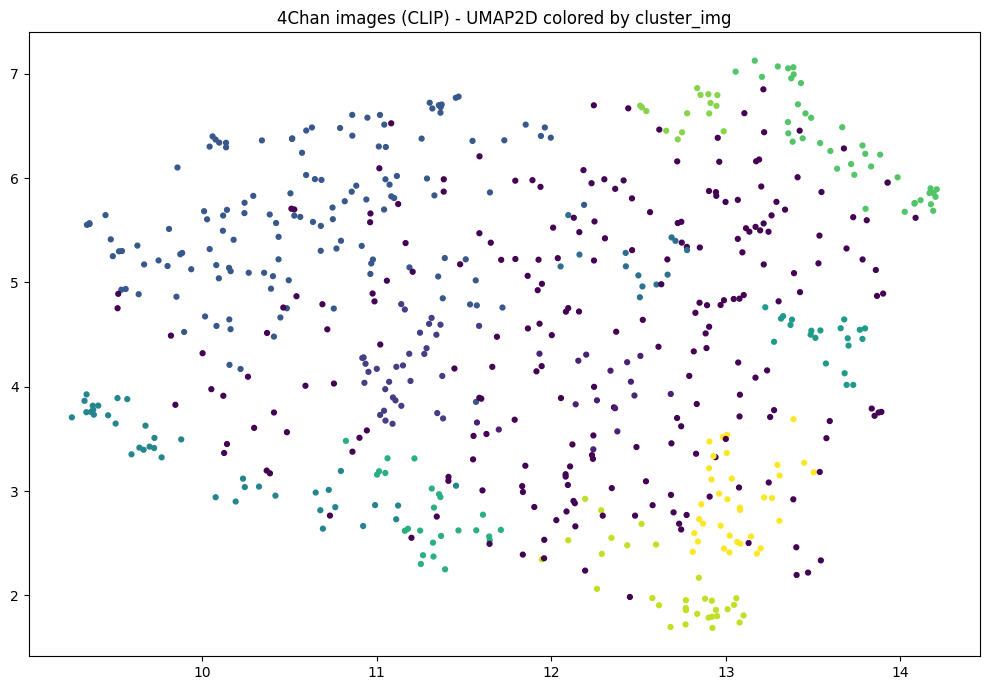

✅ Saved plot: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/CLIP_Image_Clusters_20260219/clip_umap2d_clusters.png

✅ Saved: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/CLIP_Image_Clusters_20260219/image_level_clusters.csv
✅ Saved: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/CLIP_Image_Clusters_20260219/cluster_samples_top10_by_posts.csv

RUN_DIR: /content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord/Artifacts/CLIP_Image_Clusters_20260219


In [62]:
# ================================
# Visual clustering on 4Chan images (CLIP) + diagnostics
# ================================
import os
import numpy as np
import pandas as pd

from sklearn.metrics import homogeneity_score, completeness_score
from sklearn.preprocessing import StandardScaler

import umap
import hdbscan
import matplotlib.pyplot as plt

BASE_PATH = "/content/drive/MyDrive/Pesquisa 4Chan, Reddit e Discord"

MERGE_DIR = f"{BASE_PATH}/Artifacts/4Chan_Multimodal_Merge_20260219"
DF_MERGED = f"{MERGE_DIR}/df_4chan_with_clip_idx.parquet"

CACHE_DIR = f"{BASE_PATH}/Artifacts/EmbeddingCache_Images"
CLIP_EMB_NPY = f"{CACHE_DIR}/clip_ViT-L-14_openai_4chan_embeddings.npy"
CLIP_INDEX_CSV = f"{CACHE_DIR}/clip_ViT-L-14_openai_4chan_image_index.csv"

RUN_DIR = f"{BASE_PATH}/Artifacts/CLIP_Image_Clusters_20260219"
os.makedirs(RUN_DIR, exist_ok=True)

print("="*90)
print("Loading merged df + CLIP cache")
print("="*90)

df = pd.read_parquet(DF_MERGED)
emb = np.load(CLIP_EMB_NPY)      # (626,768)
idx = pd.read_csv(CLIP_INDEX_CSV)

print("df rows:", df.shape, "| emb:", emb.shape, "| idx:", idx.shape)

# ----------------
# 1) Aggregate to one row per screenshot (image)
# ----------------
# Most columns in df are post-level. For image clustering we need image-level table.
# We'll aggregate board_guess via mode, and keep a few metadata as sanity.
def mode_or_nan(s):
    s = s.dropna()
    if len(s)==0: return np.nan
    return s.value_counts().idxmax()

img = (
    df.groupby("img_emb_idx")
      .agg(
          screenshot_file=("screenshot_file", "first"),
          screenshot_id=("screenshot_id", "first"),
          board_guess=("board", mode_or_nan),   # board column exists in your df_4chan
          visual_class=("visual_class", mode_or_nan),
          n_posts=("text_content", "size"),
          n_with_image=("has_image", lambda x: int(np.sum(x.astype(bool))) if x.notna().any() else 0),
          mean_sent=("combined_sentiment_score", lambda x: float(pd.to_numeric(x, errors="coerce").dropna().mean()) if pd.to_numeric(x, errors="coerce").dropna().size else np.nan),
      )
      .reset_index()
)

print("\nImage-level table:", img.shape)
print(img.head(3))

# sanity: all img_emb_idx should be valid
bad = img[ (img["img_emb_idx"]<0) | (img["img_emb_idx"]>=emb.shape[0]) ]
if len(bad):
    raise ValueError("Found invalid img_emb_idx values.")

X = emb[img["img_emb_idx"].values.astype(int)]

# ----------------
# 2) UMAP (10D) then HDBSCAN
# ----------------
print("\nRunning UMAP -> 10D ...")
umap10 = umap.UMAP(
    n_neighbors=25,
    min_dist=0.05,
    n_components=10,
    metric="cosine",
    random_state=42
)
X10 = umap10.fit_transform(X)

print("Running HDBSCAN ...")
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=12,
    min_samples=5,
    metric="euclidean"  # euclidean in UMAP space
)
labels = clusterer.fit_predict(X10)

img["cluster_img"] = labels
n_noise = int(np.sum(labels==-1))
n_cl = len(set(labels)) - (1 if -1 in labels else 0)

print("\nClusters found:", n_cl, "| noise:", n_noise, "of", len(img))

# ----------------
# 3) Diagnostics: "content attracts" -> do clusters align with boards/classes?
# ----------------
# NOTE: noise points (-1) distort scores; we'll compute with and without noise
def scores(y_true, y_pred, mask=None, title=""):
    if mask is None:
        mask = np.ones(len(y_true), dtype=bool)
    yt = pd.Series(y_true)[mask].astype(str)
    yp = pd.Series(y_pred)[mask].astype(int)
    # if only 1 cluster label present, scores are degenerate
    if len(set(yp)) < 2:
        print(f"{title} -> only 1 cluster after masking; scores not meaningful.")
        return
    print(f"{title} Homogeneity:", round(homogeneity_score(yt, yp), 4))
    print(f"{title} Completeness:", round(completeness_score(yt, yp), 4))

mask_non_noise = (img["cluster_img"] != -1).values

print("\n📊 Alignment diagnostics (Image clusters vs metadata)")
scores(img["board_guess"], img["cluster_img"], mask_non_noise, title="Board_guess (non-noise)")
scores(img["visual_class"], img["cluster_img"], mask_non_noise, title="Visual_class (non-noise)")

# cluster distribution
dist = img["cluster_img"].value_counts().sort_index()
print("\nCluster sizes:\n", dist.to_string())

# ----------------
# 4) UMAP 2D plot for visualization
# ----------------
print("\nRunning UMAP -> 2D for plot ...")
umap2 = umap.UMAP(
    n_neighbors=25,
    min_dist=0.05,
    n_components=2,
    metric="cosine",
    random_state=42
)
X2 = umap2.fit_transform(X)

plt.figure(figsize=(10,7))
plt.scatter(X2[:,0], X2[:,1], s=12, c=img["cluster_img"].values)
plt.title("4Chan images (CLIP) - UMAP2D colored by cluster_img")
plt.tight_layout()

plot_path = f"{RUN_DIR}/clip_umap2d_clusters.png"
plt.savefig(plot_path, dpi=200)
plt.show()
print("✅ Saved plot:", plot_path)

# ----------------
# 5) Save artifacts
# ----------------
img_out = f"{RUN_DIR}/image_level_clusters.csv"
img.to_csv(img_out, index=False)
print("\n✅ Saved:", img_out)

# Quick qualitative sampling: top 10 images per cluster by "n_posts" (proxy of content density)
samples = []
for cl in sorted([c for c in img["cluster_img"].unique() if c != -1]):
    tmp = img[img["cluster_img"]==cl].sort_values("n_posts", ascending=False).head(10).copy()
    tmp["rank_in_cluster"] = np.arange(1, len(tmp)+1)
    samples.append(tmp)

df_samples = pd.concat(samples, ignore_index=True) if samples else pd.DataFrame()
samples_out = f"{RUN_DIR}/cluster_samples_top10_by_posts.csv"
df_samples.to_csv(samples_out, index=False)
print("✅ Saved:", samples_out)

print("\nRUN_DIR:", RUN_DIR)
